<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Deep Learning for Audio Signal</div><br>
    <div style="font-size: x-large; color:gray">Assignment 1 - Audio event detection in DCASE</div><br>
    <div style="font-size: large">Francisco Javier Sáez Maldonado</div>
</div>

In [1]:
from appsa_pr1 import *
import numpy as np
from os import listdir
from os.path import isfile, join

%load_ext autoreload
%autoreload 2

# Audio segment representation and annotations

## Wave shapes and audio features

We begin by plotting a random signal of the validation set. We fix the numpy random seed so that the same signal appears in every execution. If we change the seed, the plotted signal would change. Also, recall that the `plot_waveform` function returns the loaded signal, which we can use to extract useful information.

In [17]:
np.random.seed(123)
path = DATASET_PATH + AUDIO_SUBPATH
audio_names = [f for f in listdir(path) if isfile(join(path, f))]
choice = np.random.choice(audio_names,1)[0]
print(choice)

Y0cH_NlhhMAs_30.000_40.000.wav


When we listen to this audio, we can recognize a few events:

- In the first 3 seconds, a knock on certain type of surface sounds.
- After that, a door bell rings
- Lastly, around second $7$, a few people say "Little pigs, little pigs".

Num samples     = 441000
Sample rate f_s = 44100
Total duration  = 10.0


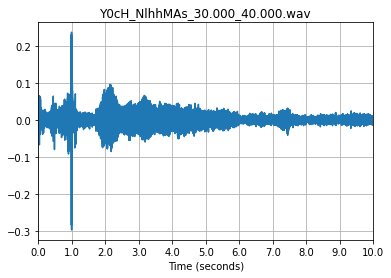

In [3]:
signal = plot_waveform(choice)
print("Num samples     = {}".format(signal[0].size))
print("Sample rate f_s = {}".format(signal[1]))
print("Total duration  = {}".format(signal[0].size / signal[1]))

- What is the sample rate $f_s$ ?

The load function from `librosa` returns both the audio timeseries `y` and the sample rate `f_s`. In this case,the  **sample rate** of $44100$ samples per second.

- What is the duration of the audio file in seconds?

We can compute it by dividing the total number of samples by the sample rate, obtaining a duration of $10$ seconds.

- Include the obtained figure in this document

We can see the obtained figure above.

### Mel-spectrogram

Let us plot the **mel-spectrogram**. We use the same audio used in the previous case (we replace in the filename the last three characters for the ones needed for the `NumPy` extension)

We include the figure and some variables that will help us on the following questions.

Mel shape : (864, 64)
Seconds   : 10.046511627906977
Total size: 55296


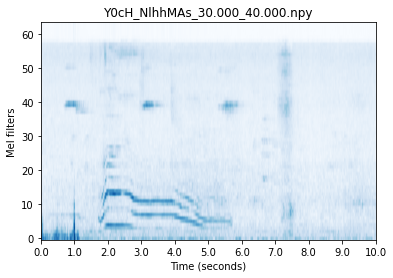

In [4]:
choice_feats_filename = choice[:-3] + 'npy'
mel = plot_melgram(choice_feats_filename)
print("Mel shape : {}".format(mel.shape))
print("Seconds   : {}".format(mel.shape[0]/86))
print("Total size: {}".format(np.prod(mel.shape)))

- How many temporal frames does the mel-spectrogram representation contains?

Inspecting the shape of the mel-spectrogram, we found that it has $864$ frames.

- How many mel filters are represented in the obtained mel-spectrogram?

Again, inspecting the shape we found that we are representing $64$ filters.

- Compare the waveform size with the mel-spectrogram size in term of the number of samples in each representation

We have seen that the original signal has $441000$ samples and the mel-spectrogram has $864 \cdot 64 = 55296$ elements, which is a little bit more of $1/10$ of the original signal, reducing the size significantly.

## Event annotation

In this section we will load the annotations of the considered example and we will make some comments about them. Let us begin by loading them.
We also assume that in the events with `NaN` annotations (no annotations for this event), we can use $0.0$ in all the cases.

In [5]:
anno_path = DATASET_PATH + META_SUBPATH + META_FILE

import pandas as pd
df = pd.read_csv(anno_path, sep = "\t", header = 0)
df = df.fillna(0)
print(df.head)

<bound method NDFrame.head of                               filename  onset  offset     event_label
0     Y00pbt6aJV8Y_350.000_360.000.wav  0.000   9.971  Vacuum_cleaner
1       Y00pK0GMmE9s_70.000_80.000.wav  0.000  10.000  Vacuum_cleaner
2       Y02sD1KJeoGA_50.000_60.000.wav  0.000  10.000          Frying
3       Y0bjUq9XMMmQ_30.000_40.000.wav  0.000  10.000          Frying
4       Y0cH_NlhhMAs_30.000_40.000.wav  1.710   6.005             Cat
...                                ...    ...     ...             ...
4246  Yb8GxUkjLSUY_628.000_638.000.wav  4.772   5.228          Speech
4247  Yb8GxUkjLSUY_628.000_638.000.wav  5.606   6.360          Speech
4248  Yb8GxUkjLSUY_628.000_638.000.wav  7.644   8.220          Speech
4249  Yb8GxUkjLSUY_628.000_638.000.wav  8.524   9.391          Speech
4250    Y86owBlJa8f0_24.000_34.000.wav  0.000   0.000               0

[4251 rows x 4 columns]>


We can now select the annotations for our audio

In [6]:
choice_annotations = df.loc[df['filename'] == choice]
print(choice_annotations)

                         filename  onset  offset event_label
4  Y0cH_NlhhMAs_30.000_40.000.wav   1.71   6.005         Cat


As we can see, there are two events in our audio:

- One in the interval of time $[3.224,5.706]$ that is an `Alarm_bell_ringing`
- The second one is in the interval of time $[7.253,9.983]$ that is `Speech`. 

Let us plot the annotations:

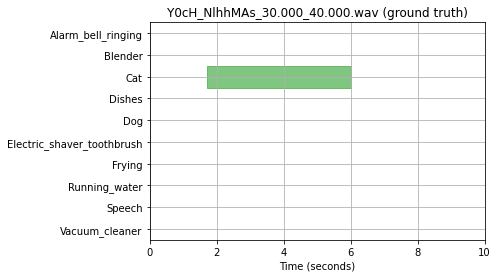

In [7]:
plot_labels(choice)

- Is there overlapping between the audio events?

We already saw in the previous description with the time intervals that there is no overlapping between the tags. The plot of the labels confirms this.

- Compare the waveform and the mel-spectrogram with the annotation, and associate the annotated audio events with the different parts of the representations

To achieve this, it we will plot the three previous graphs stacked:

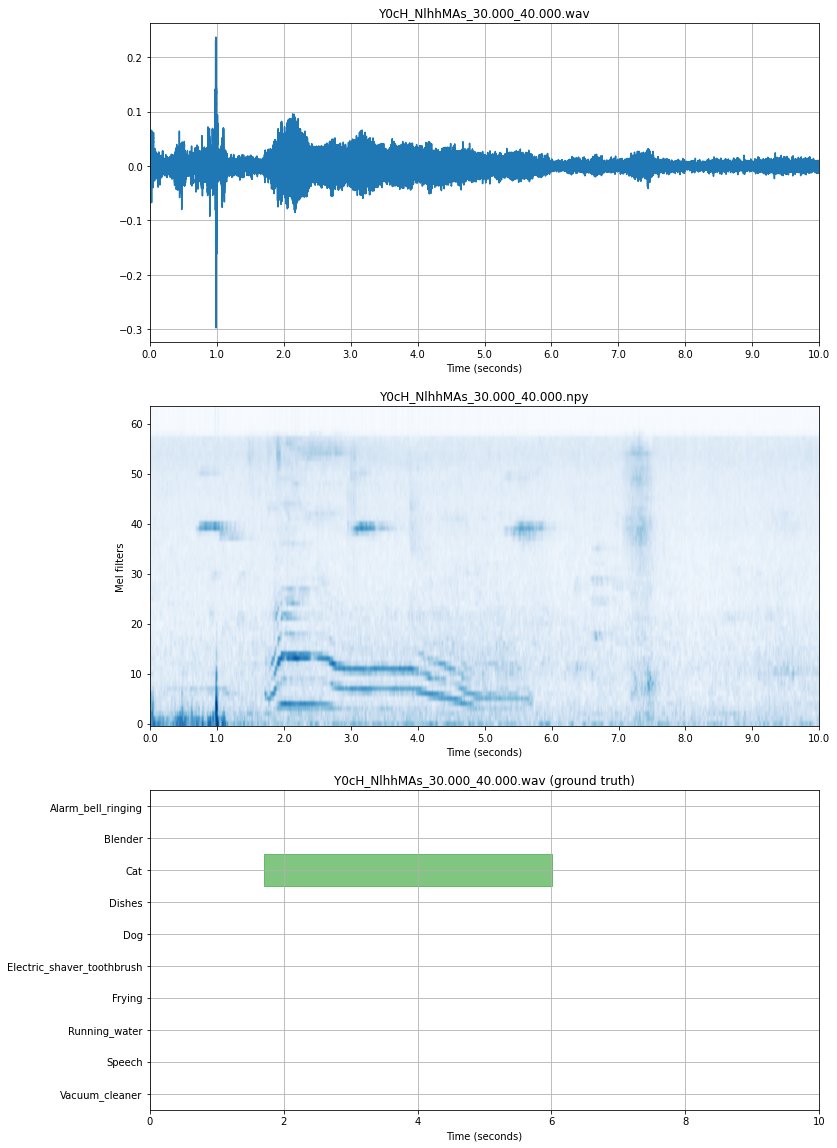

In [16]:
fig,ax = plt.subplots(3,1,figsize = (12,20))
_ = plot_waveform(choice, ax[0])
_ = plot_melgram(choice_feats_filename, ax[1])
plot_labels(choice, ax[2])

# Acoustic event dectection using a pre-trained model

## Scores and metrics

Firstly, we will execute the validation using the pretrained model. The results will be shown in the screen.

In [21]:
!python TestModel.py --model_path=pretrained_model.p

 INFO - Model loaded at epoch: 83
 INFO - dataset/metadata/validation/validation.tsv
 INFO - ../dataset/metadata/validation/validation.tsv Total file number: 1168
 INFO - Saving predictions at: validation2019_predictions.tsv
 INFO - Event based metrics (onset-offset)
  Evaluated length                  : 10459.12 sec
  Evaluated files                   : 1168 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 25.42 %
    Precision                       : 26.83 %
    Recall                          : 24.15 %
  Error rate
    Error rate (ER)                 : 1.38 
    Substitution rate               : 0.03 
    Deletion rate                   : 0.72 
    Insertion rate                  : 0.62 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)     

We are asked to comment the following metrics:

- Class-wise average metrics (macro-average)
- Class-wise metrics

We 